# Keras for Text Classification

## Learning Objectives
1. Learn how to create a text classification datasets using BigQuery.
1. Learn how to tokenize and integerize a corpus of text for training in Keras.
1. Learn how to do one-hot-encodings in Keras.
1. Learn how to use embedding layers to represent words in Keras.
1. Learn about the bag-of-word representation for sentences.
1. Learn how to use DNN/CNN/RNN model to classify text in keras.

## Introduction


In this notebook, we will implement text models to recognize the probable source (Github, Tech-Crunch, or The New-York Times) of the titles we have in the title dataset we constructed in the first task of the lab.

In the next step, we will load and pre-process the texts and labels so that they are suitable to be fed to a Keras model. For the texts of the titles we will learn how to split them into a list of tokens, and then how to map each token to an integer using the Keras Tokenizer class. What will be fed to our Keras models will be batches of padded list of integers representing the text. For the labels, we will learn how to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will explore a few possible models to do the title classification. All models will be fed padded list of integers, and all models will start with a Keras Embedding layer that transforms the integer representing the words into dense vectors.

The first model will be a simple bag-of-word DNN model that averages up the word vectors and feeds the tensor that results to further dense layers. Doing so means that we forget the word order (and hence that we consider sentences as a “bag-of-words”). In the second and in the third model we will keep the information about the word order using a simple RNN and a simple CNN allowing us to achieve the same performance as with the DNN model but in much fewer epochs.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/keras_for_text_classification.ipynb).

In [1]:
import os

from google.cloud import bigquery
import pandas as pd

In [2]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Replace the variable values in the cell below:

In [3]:
PROJECT = "qwiklabs-gcp-02-d80de3c3d67e"  # Replace with your PROJECT
BUCKET = PROJECT  # defaults to PROJECT
REGION = "europe-west1"  # Replace with your REGION
SEED = 0

## Create a Dataset from BigQuery 

Hacker news headlines are available as a BigQuery public dataset. The [dataset](https://console.cloud.google.com/bigquery?project=bigquery-public-data&page=table&t=full&d=hacker_news&p=bigquery-public-data&redirect_from_classic=true) contains all headlines from the sites inception in October 2006 until October 2015. 

### Lab Task 1a: 
Complete the query below to create a sample dataset containing the `url`, `title`, and `score` of articles from the public dataset `bigquery-public-data.hacker_news.full`. Use a WHERE clause to restrict to only those articles with
* title length greater than 10 characters
* score greater than 10
* url length greater than 0 characters

In [4]:
%%bigquery --project $PROJECT

SELECT
    url, title, score
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    LENGTH(title) > 10 AND 
    score > 10 AND
    LENGTH(url) > 0 
LIMIT 10

Query is running:   0%|          |

/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2438: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2452: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2466: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,url,title,score
0,http://www.paulrhayes.com/experiments/sphere/,3D Sphere created using CSS 3D transforms,11
1,https://www.bloomberg.com/news/articles/2022-1...,China Plans to Build Nuclear-Powered Moon Base...,11
2,https://nathanchance.dev/posts/2022-cbl-retros...,2022 ClangBuiltLinux Retrospective,11
3,https://www.npr.org/2022/12/28/1145709106/nyc-...,NYC could lose 10k Airbnb listings due to new ...,11
4,https://www.bbc.com/news/the-reporters-63622746,Alan MacMasters: How the great online toaster ...,11
5,https://www.wired.com/story/machine-learning-a...,Machine Learning could create the perfect game...,11
6,https://www.forbes.com/sites/alanohnsman/2023/...,Tesla Calling Its Cars “Full Self-Driving” May...,11
7,https://www.nytimes.com/2023/01/06/well/eat/me...,The Mediterranean Diet Is That Good for You. H...,11
8,https://kottke.org/22/12/our-first-closeup-ima...,Our First Closeup Image of Mars Was a Paint-by...,11
9,https://learn.microsoft.com/en-us/windows/win3...,“a drink” user attribute in active directory,11


Let's do some regular expression parsing in BigQuery to get the source of the newspaper article from the URL. For example, if the url is http://mobile.nytimes.com/...., I want to be left with <i>nytimes</i>

### Lab task 1b:
Complete the query below to count the number of titles within each 'source' category. Note that to grab the 'source' of the article we use the a regex command on the `url` of the article. To count the number of articles you'll use a `GROUP BY` in sql, and we'll also restrict our attention to only those articles whose title has greater than 10 characters.

In [5]:
%%bigquery --project $PROJECT

SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[safe_offset (1)] AS source,
    COUNT(title) AS num_articles
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10 
GROUP BY
    source
ORDER BY num_articles DESC
  LIMIT 100

Query is running:   0%|          |

/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2438: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2452: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2466: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,source,num_articles
0,github,197983
1,medium,135939
2,youtube,135177
3,nytimes,87365
4,blogspot,62619
...,...,...
95,nextplatform,3235
96,itworld,3161
97,atlasobscura,3108
98,oreilly,3018


Now that we have good parsing of the URL to get the source, let's put together a dataset of source and titles. This will be our labeled dataset for machine learning.

In [6]:
regex = '.*://(.[^/]+)/'


sub_query = """
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '{0}'), '.'))[safe_offset (1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '{0}'), '.com$')
    AND LENGTH(title) > 10
""".format(regex)


query = """
SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  ({sub_query})
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')
""".format(sub_query=sub_query)

print(query)


SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  (
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[safe_offset (1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
)
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')



For ML training, we usually need to split our dataset into training and evaluation datasets (and perhaps an independent test dataset if we are going to do model or feature selection based on the evaluation dataset). AutoML however figures out on its own how to create these splits, so we won't need to do that here. 



In [7]:
bq = bigquery.Client(project=PROJECT)
title_dataset = bq.query(query).to_dataframe()
title_dataset.head()

/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2438: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2452: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2466: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


,title,source
0,convert your web application to native applica...,github
1,show hn standardising unit tests for prompts,github
2,versta private offline google translate alte...,github
3,rkaggle bring kaggle datasets straight into t...,github
4,show hn pipzap zapping the mess out of the ...,github


AutoML for text classification requires that
* the dataset be in csv form with 
* the first column being the texts to classify or a GCS path to the text 
* the last colum to be the text labels

The dataset we pulled from BiqQuery satisfies these requirements.

In [8]:
print("The full dataset contains {n} titles".format(n=len(title_dataset)))

The full dataset contains 345893 titles


Let's make sure we have roughly the same number of labels for each of our three labels:

In [9]:
title_dataset.source.value_counts()

source
github        197983
nytimes        87365
techcrunch     60545
Name: count, dtype: int64

Finally we will save our data, which is currently in-memory, to disk.

We will create a csv file containing the full dataset and another containing only 1000 articles for development.

**Note:** It may take a long time to train AutoML on the full dataset, so we recommend to use the sample dataset for the purpose of learning the tool. 


In [10]:
DATADIR = './data/'

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [11]:
FULL_DATASET_NAME = 'titles_full.csv'
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Let's shuffle the data before writing it to disk.
title_dataset = title_dataset.sample(n=len(title_dataset))

title_dataset.to_csv(
    FULL_DATASET_PATH, header=False, index=False, encoding='utf-8')

Now let's sample 1000 articles from the full dataset and make sure we have enough examples for each label in our sample dataset (see [here](https://cloud.google.com/natural-language/automl/docs/beginners-guide) for further details on how to prepare data for AutoML).

### Lab Task 1c:
Use `.sample` to create a sample dataset of 1,000 articles from the full dataset. Use `.value_counts` to see how many articles are contained in each of the three source categories?

In [12]:
sample_title_dataset = title_dataset.sample(1000)


In [13]:
sample_title_dataset.describe()

,title,source
count,1000,1000
unique,1000,3
top,find and fix dangling files and unused depende...,github
freq,1,556


Let's write the sample datatset to disk.

In [14]:
SAMPLE_DATASET_NAME = 'titles_sample.csv'
SAMPLE_DATASET_PATH = os.path.join(DATADIR, SAMPLE_DATASET_NAME)

sample_title_dataset.to_csv(
    SAMPLE_DATASET_PATH, header=False, index=False, encoding='utf-8')

In [15]:
sample_title_dataset.head()

,title,source
32587,find and fix dangling files and unused depende...,github
216269,an a.i.-generated spoof rattles the markets,nytimes
88301,lacinia graphql for clojure,github
92053,inject this js snippet to bypass t.co urls on ...,github
275593,on darwin s on the origin of species,nytimes


In [16]:
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.layers import (
    Embedding,
    Flatten,
    GRU,
    Conv1D,
    Lambda,
    Dense,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


print(tf.__version__)

2026-02-05 14:39:20.755837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-05 14:39:22.344519: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2026-02-05 14:39:22.344755: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local

2.11.0


In [17]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [18]:
LOGDIR = "./text_models"
DATA_DIR = "./data"

## Loading the dataset

Our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, Tech-Crunch, or the New-York Times).

In [19]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,setting up a blog with node.js,github
1,gocrosscampus,nytimes
2,things i ve learned in 5 years of javascript,github
3,apple largely prevails in appeal of epic games...,nytimes
4,show hn covalent distributed computing for ...,github


## Integerize the texts

The first thing we need to do is to find how many words we have in our dataset (`VOCAB_SIZE`), how many titles we have (`DATASET_SIZE`), and what the maximum length of the titles we have (`MAX_LEN`) is. Keras offers the `Tokenizer` class in its `keras.preprocessing.text` module to help us with that:

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(titles_df.title)

In [21]:
integerized_titles = tokenizer.texts_to_sequences(titles_df.title)
integerized_titles[:3]

[[2662, 63, 1, 632, 11, 66, 32],
 [52017],
 [581, 33, 773, 1399, 7, 135, 291, 9, 46]]

In [22]:
VOCAB_SIZE = len(tokenizer.index_word)
VOCAB_SIZE

110498

In [23]:
DATASET_SIZE = tokenizer.document_count
DATASET_SIZE

345893

In [24]:
MAX_LEN = max(len(sequence) for sequence in integerized_titles)
MAX_LEN

26

Let's now implement a function `create_sequence` that will 
* take as input our titles as well as the maximum sentence length and 
* returns a list of the integers corresponding to our tokens padded to the sentence maximum length

Keras has the helper functions `pad_sequence` for that on the top of the tokenizer methods.

### Lab Task #2:
Complete the code in the `create_sequences` function below to
* create text sequences from `texts` using the tokenizer we created above 
* pad the end of those text sequences to have length `max_len`

In [25]:
# TODO 1
def create_sequences(texts, max_len=MAX_LEN):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, max_len, padding="post")
    return padded_sequences

In [26]:
sequences = create_sequences(titles_df.title[:3])
sequences

array([[ 2662,    63,     1,   632,    11,    66,    32,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [52017,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [  581,    33,   773,  1399,     7,   135,   291,     9,    46,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [27]:
titles_df.source[:4]

0     github
1    nytimes
2     github
3    nytimes
Name: source, dtype: object

We now need to write a function that 
* takes a title source and
* returns the corresponding one-hot encoded vector

Keras `to_categorical` is handy for that.

In [28]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

### Lab Task #3:
Complete the code in the `encode_labels` function below to
* create a list that maps each `source` in `sources` to its corresponding numeric value using the dictionary `CLASSES` above
* use the Keras function to one-hot encode the variable classes

In [29]:
# TODO 2
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes)
    return one_hots

In [30]:
encode_labels(titles_df.source[:4])

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

## Preparing the train/test splits

Let's split our data into train and test splits:

In [31]:
N_TRAIN = int(DATASET_SIZE * 0.80) # TREINO (80%)/ VALID (20%)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per classes.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.


In [32]:
sources_train.value_counts()

source
github        158453
nytimes        69862
techcrunch     48399
Name: count, dtype: int64

In [33]:
sources_valid.value_counts()

source
github        39530
nytimes       17503
techcrunch    12146
Name: count, dtype: int64

Using `create_sequence` and `encode_labels`, we can now prepare the
training and validation data to feed our models.

The features will be
padded list of integers and the labels will be one-hot-encoded 3D vectors.

In [34]:
X_train, Y_train = create_sequences(titles_train), encode_labels(sources_train)
X_valid, Y_valid = create_sequences(titles_valid), encode_labels(sources_valid)

In [35]:
X_train[:3]

array([[ 2662,    63,     1,   632,    11,    66,    32,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [52017,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [  581,    33,   773,  1399,     7,   135,   291,     9,    46,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [36]:
Y_train[:3]

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

## Building a DNN model

The build_dnn_model function below returns a compiled Keras model that implements a simple embedding layer transforming the word integers into dense vectors, followed by a Dense softmax layer that returns the probabilities for each class.


Note that we need to put a custom Keras Lambda layer in between the Embedding layer and the Dense softmax layer to do an average of the word vectors returned by the embedding layer. This is the average that's fed to the dense softmax layer. By doing so, we create a model that is simple but that loses information about the word order, creating a model that sees sentences as "bag-of-words".

### Lab Tasks #4, #5, and #6:
Create a Keras Sequential model with three layers:
* The first layer should be an embedding layer with output dimension equal to `embed_dim`.
* The second layer should use a Lambda layer to create a bag-of-words representation of the sentences by computing the mean.
* The last layer should use a Dense layer to predict which class the example belongs to.

In [37]:
# TODOs 4-6
def build_dnn_model(embed_dim):

    model = Sequential([
        Embedding(VOCAB_SIZE+1, embed_dim, input_shape=[MAX_LEN]), # vocab inteiro + dimensao embed + tamanho input
        Lambda(lambda x: tf.reduce_mean(x, axis=1)), # computando a média do axis 1 
        Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Below we train the model on 100 epochs but adding an `EarlyStopping` callback that will stop the training as soon as the validation loss has not improved after a number of steps specified by `PATIENCE` . Note that we also give the `model.fit` method a Tensorboard callback so that we can later compare all the models using TensorBoard.

2026-02-05 14:39:41.552264: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2026-02-05 14:39:41.552317: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2026-02-05 14:39:41.552344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lab-workbench): /proc/driver/nvidia/version does not exist
2026-02-05 14:39:41.552664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other 

Epoch 1/100
923/923 [==============================] - 15s 15ms/step - loss: 0.7533 - accuracy: 0.6595 - val_loss: 0.5363 - val_accuracy: 0.7636
Epoch 2/100
923/923 [==============================] - 16s 17ms/step - loss: 0.4493 - accuracy: 0.8152 - val_loss: 0.3901 - val_accuracy: 0.8572
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 10)            1104990   
                                                                 
 lambda (Lambda)             (None, 10)                0         
                                                                 
 dense (Dense)               (None, 3)                 33        
                                                                 
Total params: 1,105,023
Trainable params: 1,105,023
Non-trainable params: 0
_________________________________________________________________
CPU times: user 51 s

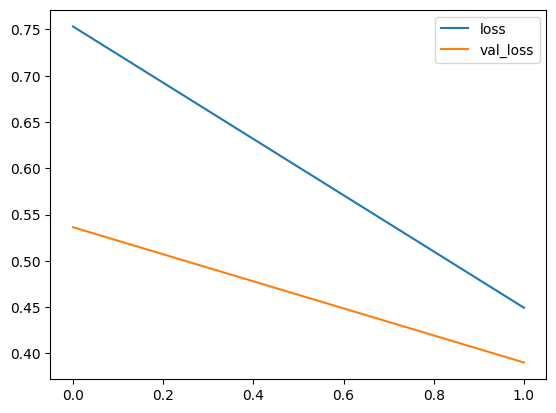

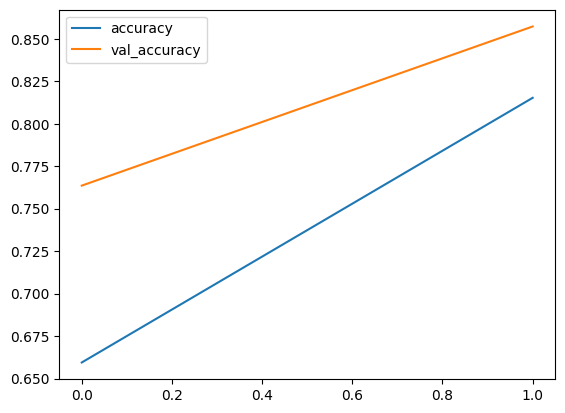

In [38]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'dnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 0

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)

dnn_history = dnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(dnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(dnn_history.history)[['accuracy', 'val_accuracy']].plot()

dnn_model.summary()

## Building a RNN model

The `build_dnn_model` function below returns a compiled Keras model that implements a simple RNN model with a single `GRU` layer, which now takes into account the word order in the sentence.

The first and last layers are the same as for the simple DNN model.

Note that we set `mask_zero=True` in the `Embedding` layer so that the padded words (represented by a zero) are ignored by this and the subsequent layers.


### Lab Task #4 and #6:
Complete the code below to build an RNN model which predicts the article class. The code below is similar to the DNN you created above; however, here we do not need to use a bag-of-words representation of the sentence. Instead, you can pass the embedding layer directly to an RNN/LSTM/GRU layer.

In [39]:
def build_rnn_model(embed_dim, units):

    model = Sequential([
        Embedding(VOCAB_SIZE+1, embed_dim, input_shape=[MAX_LEN], mask_zero=True), # vocab inteiro + dimensao embed + tamanho input
        GRU(units),
        Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's train the model with early stoping as above. 

Observe that we obtain the same type of accuracy as with the DNN model, but in less epochs (~3 v.s. ~20 epochs):

COMECEEEEEEEEEEIIIIIIIIIIIIII@!!!!!!!!!!!
Epoch 1/100
923/923 [==============================] - 46s 44ms/step - loss: 0.4007 - accuracy: 0.8287 - val_loss: 0.2508 - val_accuracy: 0.9046
Epoch 2/100
923/923 [==============================] - 46s 50ms/step - loss: 0.2051 - accuracy: 0.9229 - val_loss: 0.2387 - val_accuracy: 0.9098
ACABEI@!!!!!!!!!!!
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 26, 10)            1104990   
                                                                 
 gru (GRU)                   (None, 16)                1344      
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 1,106,385
Trainable params: 1,106,385
Non-trainable params: 0
_______________________

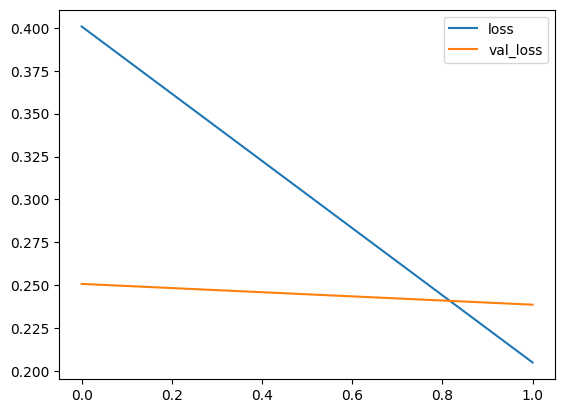

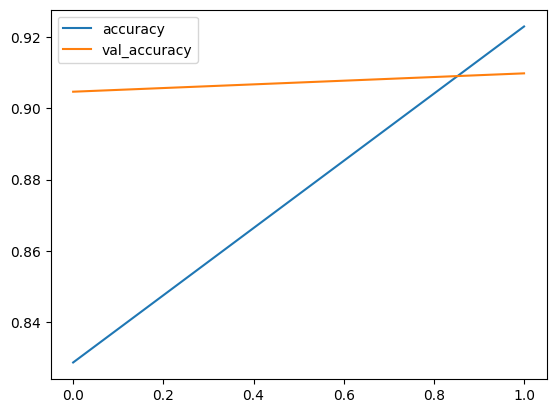

In [40]:
%%time

tf.random.set_seed(33)
print("COMECEEEEEEEEEEIIIIIIIIIIIIII@!!!!!!!!!!!")
MODEL_DIR = os.path.join(LOGDIR, 'rnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 10
UNITS = 16
PATIENCE = 0

rnn_model = build_rnn_model(embed_dim=EMBED_DIM, units=UNITS)

history = rnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
print("ACABEI@!!!!!!!!!!!")

rnn_model.summary()

## Build a CNN model

The `build_dnn_model` function below returns a compiled Keras model that implements a simple CNN model with a single `Conv1D` layer, which now takes into account the word order in the sentence.

The first and last layers are the same as for the simple DNN model, but we need to add a `Flatten` layer betwen the convolution and the softmax layer.

Note that we set `mask_zero=True` in the `Embedding` layer so that the padded words (represented by a zero) are ignored by this and the subsequent layers.


### Lab Task #4 and #6
Complete the code below to create a CNN model for text classification. This model is similar to the previous models in that you should start with an embedding layer. However, the embedding next layers should pass through a 1-dimensional convolution and ultimately the final fully connected, dense layer. Use the arguments of the `build_cnn_model` function to set up the 1D convolution layer. 

In [45]:
def build_cnn_model(embed_dim, filters, ksize, strides):

    model = Sequential([
        Embedding(VOCAB_SIZE+1, embed_dim, input_shape=[MAX_LEN], mask_zero=True),
        Conv1D(filters=filters,kernel_size=ksize,
              strides=strides,
              activation='relu'),
        Flatten(), 
        Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's train the model. 

Again we observe that we get the same kind of accuracy as with the DNN model but in many fewer steps.



Epoch 1/100
923/923 [==============================] - 16s 16ms/step - loss: 0.3620 - accuracy: 0.8475 - val_loss: 0.2468 - val_accuracy: 0.9041
Epoch 2/100
923/923 [==============================] - 16s 17ms/step - loss: 0.1984 - accuracy: 0.9243 - val_loss: 0.2375 - val_accuracy: 0.9095
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 26, 5)             552495    
                                                                 
 conv1d (Conv1D)             (None, 12, 200)           3200      
                                                                 
 flatten (Flatten)           (None, 2400)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                 7203      
                                                                 
Total params: 562,898
Traina

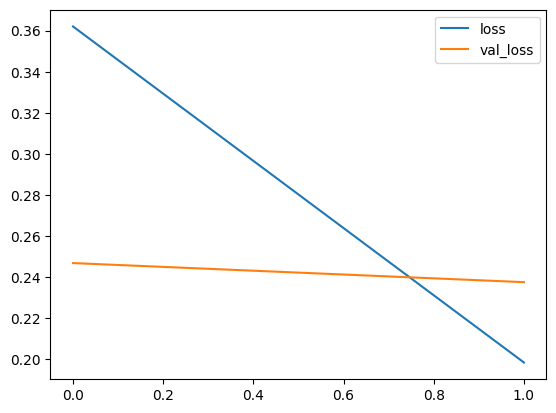

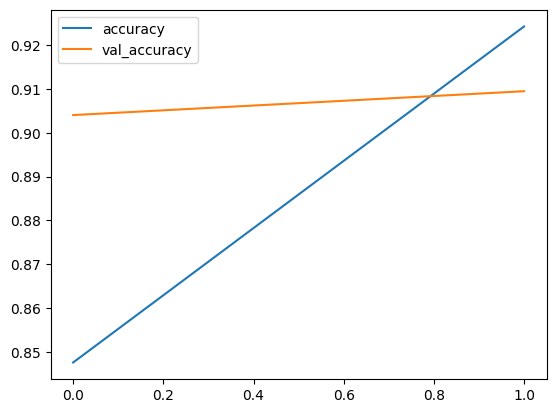

In [46]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'cnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 5
FILTERS = 200
STRIDES = 2
KSIZE = 3
PATIENCE = 0


cnn_model = build_cnn_model(
    embed_dim=EMBED_DIM,
    filters=FILTERS,
    strides=STRIDES,
    ksize=KSIZE,
)

cnn_history = cnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(cnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(cnn_history.history)[['accuracy', 'val_accuracy']].plot()

cnn_model.summary()

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License